In [166]:
import os
import numpy as np
import pandas as pd 
import glob
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# navigate to the project folder
os.chdir('C:/Users/jreyna/Documents/Projects/cmi-pb-multiomics/third_challenge')

# setting the output dir
outdir = 'results/main/model_devel/'
os.makedirs(outdir, exist_ok=True)

In [167]:
model_dict = {'lr': LinearRegression, 
              'lasso': Lasso,
              'elastic_net': ElasticNet, 
              'lasso_cv': LassoCV,
              'elastic_net_cv': ElasticNetCV}

cmodel = 'lr'
#cmodel = 'lasso'
#cmodel = 'elastic_net'
#cmodel = 'lasso_cv'
#cmodel = 'elastic_net_cv'
cmodel_function = model_dict[cmodel]

## Loading the loading matrices

In [168]:
loadings = {} 
tpl = "results/main/cmi_pb_datasets/processed/training_data/*.jive-loadings.tsv"
for loading_fn in glob.glob(tpl):
    
    bn = os.path.basename(loading_fn)
    assay = bn.split('.')[0]
    loadings_matrix = pd.read_table(loading_fn)
    loadings[assay] = loadings_matrix

## Loading the input data

In [169]:
# setting up dictionaries to load data and results
features = {}
outcomes = {}

#### Extracting Features (calculating the reduced form of each omic)

In [170]:
with open('results/main/cmi_pb_datasets/processed/training_data/common_samples.txt', 'r') as f:
    common_samples = [int(x.strip()) for x in f.readlines()]

In [171]:
tpl = 'results/main/cmi_pb_datasets/processed/training_data/*.training-data.tsv'
for raw_fn in glob.glob(tpl):  
    
    bn = os.path.basename(raw_fn)
    assay = bn.split('.')[0]
    
    # Loading the raw matrices
    raw = pd.read_table(raw_fn, index_col=0, header=0)
    shared_columns = loadings[assay].index.tolist()
    raw = raw.loc[common_samples, shared_columns]
    raw_array = np.matrix(raw.values)
    
    ## Calculating the sample factor matrix
    loadings_array = np.matrix(loadings[assay].values)
    sample_factors = raw_array * loadings_array

    tdf = pd.DataFrame(sample_factors) 
    tdf.columns = ['{}-{}'.format(assay, i) for i in range(sample_factors.shape[1])]
    features[assay] = tdf
    features[assay].index = raw.index.tolist()

In [172]:
features['final'] = pd.concat([features['pbmc_cell_frequency'],
                                     features['plasma_cytokine_concentration'],
                                     features['pbmc_gene_expression'],
                                     features['plasma_ab_titer']], axis=1)

In [173]:
features['final'].head()

,pbmc_cell_frequency-0,pbmc_cell_frequency-1,pbmc_cell_frequency-2,pbmc_cell_frequency-3,pbmc_cell_frequency-4,pbmc_cell_frequency-5,pbmc_cell_frequency-6,pbmc_cell_frequency-7,pbmc_cell_frequency-8,pbmc_cell_frequency-9,...,plasma_ab_titer-0,plasma_ab_titer-1,plasma_ab_titer-2,plasma_ab_titer-3,plasma_ab_titer-4,plasma_ab_titer-5,plasma_ab_titer-6,plasma_ab_titer-7,plasma_ab_titer-8,plasma_ab_titer-9
4,-0.899481,-0.248604,-10.404743,-2.675013,-3.905235,-5.722349,-7.721928,-2.952878,-5.112688,2.449012,...,207.721176,-4143.724467,-10570.890199,1595.084781,209.779727,943.404765,5883.295445,819.760559,2550.683669,-946.987188
6,-0.975855,-4.822534,-17.700483,-3.526054,-7.882918,-7.843105,-13.171058,-10.353981,-13.950849,6.104866,...,-545.955990,-1388.340288,-1276.091581,1500.077146,-384.746655,-1374.882186,859.613555,-803.365398,675.752387,-702.198650
11,-3.368699,1.786367,-21.795938,-6.008265,-13.630948,-13.465657,-8.068319,-5.275370,-18.459526,5.349103,...,102.573975,-4643.945910,-11476.334036,2030.730576,-292.160455,-21.900707,6760.526613,-110.648668,3921.619381,-1349.028956
15,-2.108057,2.420816,-18.423573,-1.754734,-4.328800,-8.064753,-17.031443,-7.080065,-10.975928,9.315590,...,-1116.572078,-2887.424132,-2598.234794,3242.620403,-898.165258,-2944.937584,1772.398294,-1538.736369,1157.554280,-1360.770398
17,-2.081917,1.393675,-18.229594,-1.359508,-7.673578,-9.737192,-13.270752,-2.763658,-16.151179,6.592004,...,-2211.872895,-5732.121659,-11856.478106,6536.143169,1564.434357,642.946422,5429.275067,438.605936,-533.225884,-3831.388535


#### Extracting Outcomes

In [174]:
fn = 'results/main/cmi_pb_datasets/processed/all_versus_all/harmonized/task_matrix.common_names.mfi_raw.tsv'
outcomes = pd.read_table(fn)
outcomes = outcomes.loc[outcomes.subject_id.isin(common_samples)]

In [175]:
outcomes.shape

(46, 7)

## Modelling 

#### Extracting Train/Test Splits 

In [176]:
# constructing the model object
# use max_iter as needed
if cmodel in ['lr']:
    lr_model = cmodel_function()
elif cmodel in ['lasso', 'elastic_net', 'lasso_cv', 'elastic_net_cv']:
    lr_model = cmodel_function(max_iter=100000)

# setting up necessary vars/objs
results = []
cv_splitter = KFold(5)
cv_splitter.get_n_splits(features['final'], outcomes)

for task in outcomes.columns.tolist()[1:]:
    
    for i, (train_index, test_index) in enumerate(cv_splitter.split(features['final'])):
        
        # extracting each split of the data
        X_train = features['final'].iloc[train_index]
        X_test = features['final'].iloc[test_index]
        y_train = outcomes[task].iloc[train_index]
        y_test = outcomes[task].iloc[test_index]

        # fit the model
        lr_model.fit(X_train.values, y_train.values)

        # make predictions for the test features
        preds = lr_model.predict(X_test.values)
        
        # calculate spearman'
        corr = scipy.stats.spearmanr(y_test.values, preds) 
        results.append([task, i, corr.correlation, corr.pvalue])
    


In [177]:
# convert the results into a df
results_df = pd.DataFrame(results)
results_df.columns = ['task', 'cv', 'spearman_coef', 'pvalue']

In [178]:
results_df.head()

,task,cv,spearman_coef,pvalue
0,IgG-PT.day14,0,-0.296970,0.404702
1,IgG-PT.day14,1,0.050000,0.898353
2,IgG-PT.day14,2,0.266667,0.487922
3,IgG-PT.day14,3,0.166667,0.668231
4,IgG-PT.day14,4,0.166667,0.668231


In [179]:
task_results = results_df.groupby('task')

In [180]:
summary_df = task_results.spearman_coef.describe().T

In [181]:
summary_df.head()

task,ENSG00000277632.day3,ENSG00000277632.fold-change-day3/0,IgG-PT.day14,IgG-PT.fold-change-day14/0,Monocytes.day1,Monocytes.fold-change-day1/0
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,-0.186364,-0.159697,0.070606,-0.124545,0.178788,0.159091
std,0.248115,0.482735,0.219335,0.254891,0.415015,0.274339
min,-0.516667,-0.650000,-0.296970,-0.383333,-0.406061,-0.200000
25%,-0.266667,-0.350000,0.050000,-0.272727,0.050000,0.078788


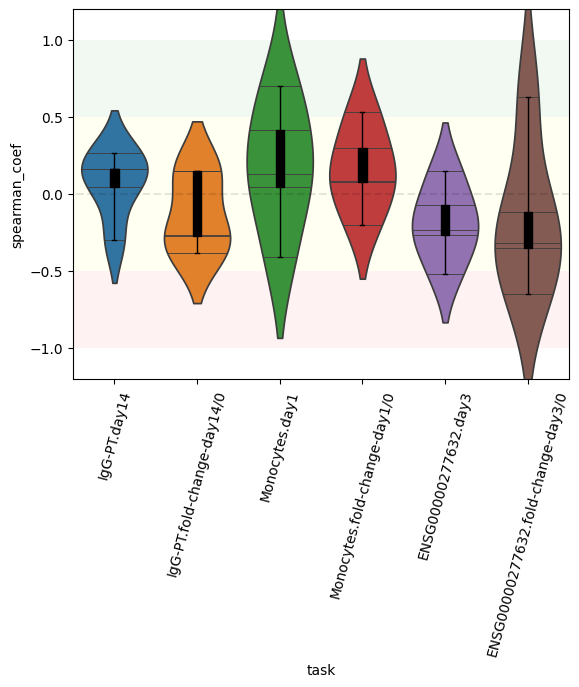

In [182]:
fig, ax = plt.subplots()

# add boundary areas
alpha = 0.05
ax.add_patch(Rectangle((-1, -1), 7, 0.5, facecolor='red', alpha=alpha))
ax.add_patch(Rectangle((-1, -0.5), 7, 1, facecolor='yellow', alpha=alpha))
ax.add_patch(Rectangle((-1, 0.5), 7, 0.5, facecolor='green', alpha=alpha))

# add lines
alpha = 0.1
ls = 'dashed'
ax.hlines(y=0, xmin=-1, xmax=6, color='black', alpha=alpha, linestyles=ls)
ax.set_ylim(-1.2, 1.2)

# add main plots
sns.violinplot(x='task', y='spearman_coef', hue='task', data=results_df, inner='stick', cut=1.75, ax=ax)
sns.boxplot(x='task', y='spearman_coef', color='black', data=results_df, width=0.1, saturation=0.1, whis=20, ax=ax)

# rotate xticks
ax.tick_params(axis='x', labelrotation=75)

fig_fn = os.path.join(outdir, 'fivefold-cross-validation.violinplot.{}.png'.format(cmodel))
fig.savefig(fig_fn, dpi=600)